In [1]:
import pandas as pd
import numpy as np
import gensim
import PyPDF2
from gensim.models import word2vec
import os

# import get_umls_concepts as umls

print('libraries imported')

libraries imported


##### Training Set and Concept Tags

A custom set of *one-gram* and *bi-gram* concept tags was created by me through filtering a combination of WHO's Health System Challenges and Health Focus Areas, in addition to our concept tags stored in Implementome's database. 

The objective being to find other terms (potential tags) which are the most relevant and similar to these tags using a cosine similarity measure between word vectors produced by the **word2vec** algorithm. After this modelling process is established, the next step should be to compare them to *MeSH* terms in order to produce more efficient and advanced queries for publications in PubMed, publications which will be used to create our custom training and testing sets that will be the inputs of our pre-trained Multi-Label Classification Model using *transformers*.

In [2]:
## our own tags
tags_df = pd.read_excel('data/all_tags_word2vec.xlsx')
tags_df

,One Word Tags,Bigram Tags (Med)
0,diagnostics,unplanned_pregnancy
1,cybersecurity,patient_empowerment
2,who,world_health
3,infertility,risk_mitigation
4,humanitarian,social_protection
...,...,...
98,NaN,digital_illiteracy
99,NaN,conditional_aid
100,NaN,health_workforce
101,NaN,doctors_shortage


Converting them from a Pandas dataframe to lists, skipping any *NaN* value.

In [3]:
one_word_tags = [x for x in tags_df['One Word Tags'].values.tolist() if pd.isna(x) == False]
bigram_tags = [x for x in tags_df['Bigram Tags (Med)'].values.tolist() if pd.isna(x) == False]

It was found that links that were part of the original text set, were not being removed when the tokenization pre-processing process happened. Therefore the function below was created using Python's regular expressions operations in order to remove any links that are found in the text set.

In [4]:
import re

def remove_links(review):
  review = re.sub(r'https?:\/\/.*[\r\n]*', '', review)
  return review

link_example = "To purchase WHO publications, see http://apps.who.int/bookorders. For requests, see http://www.who.int/about/licensing"
print('Original: {}'.format(link_example))
print('Pre-processed: {}'.format(remove_links(link_example)))

Original: To purchase WHO publications, see http://apps.who.int/bookorders. For requests, see http://www.who.int/about/licensing
Pre-processed: To purchase WHO publications, see 


Removing letter accents from words was set to True.

In [5]:
gensim.utils.deaccent('Universitè de Genève')

'Universite de Geneve'

#### The Train Set

The raw text dataframe that will be used to train the model, as it was produced by the concatenation of many of the publications stored in our database into a single text file. A result produced by the script file named *pdfs_to_textfile.py*. 

(19000 rows consisting of sentences were produced. however it is still considered a *small* training set so a manual selection of other publications and reearch papers will need to be added)

In [6]:
text_set_df = pd.read_table("data/train_sets/train_implementome.txt", header = None, names=['Sentences'], lineterminator='\n')
text_set_df = text_set_df.dropna(subset=['Sentences']) ## Dropping NaN values
text_set_df

,Sentences
0,original reportsImpact of High-Dose-Rate Brach...
1,Training via Telehealth in Low- and\r
2,Middle-Income Countries\r
3,"Jeremy B. Hatcher, BS1,2; Oluwadamilola Olader..."
4,"Adam Shulman, MS1,4; Claire Dempsey, PhD5,6; L..."
...,...
48254,20. To ensure that WHO streamlines the archit...
48255,21. To promote research for health within UNE...
48256,22. To urge the World Bank Group and regional...
48257,23. To evaluate the effectiveness and value o...


The result of the training set of sentences after having passed through the removal of links and tokenization (explain) processes.

In [7]:
text_set_df['Sentences'] = text_set_df['Sentences'].apply(lambda x: remove_links(x))
train_text = text_set_df['Sentences'].apply(lambda x: gensim.utils.simple_preprocess(x, min_len = 3, deacc=True))
train_text

0        [original, reportsimpact, high, dose, rate, br...
1                    [training, via, telehealth, low, and]
2                              [middle, income, countries]
3        [jeremy, hatcher, oluwadamilola, oladeru, bett...
4        [adam, shulman, claire, dempsey, phd, layth, m...
                               ...                        
48254    [ensure, that, who, streamlines, the, architec...
48255    [promote, research, for, health, within, unesc...
48256    [urge, the, world, bank, group, and, regional,...
48257    [evaluate, the, effectiveness, and, value, the...
48258    [explore, the, feasibility, establishing, nove...
Name: Sentences, Length: 48256, dtype: object

Only 'sentences' that have more than three words in them were kept for the final testing set output that will be passed to the model. (A list compromised of lists of strings)

In [8]:
train_set = [sentence for sentence in train_text if sentence != [] and len(sentence) > 3]
all_lengths = [len(x) for x in train_set]
print('Train set sentences - Minimum Length: {}, Mean Length: {}, Max Length: {}'.format(min(all_lengths), sum(all_lengths) / len(all_lengths) , max(all_lengths)))

Train set sentences - Minimum Length: 4, Mean Length: 8.525796266208884, Max Length: 225


#### Detecting bigrams and trigram tags

Given our stream of sentences, use *gensim.models.phrases* to automatically detect multi-word expressions. We are looking to detect as many correct bigram (sometimes even trigrams) terms as possible that will be compared with our bigram concept tags in terms of similarity. A small sample of what is being computed is printed below.

A word $a$ is joined by word $b$ to create a bigram phrase based on a scoring threshold for which we set the parameter. The scoring function used is the *Normalized (Pointwise) Mutual Information*.

In [16]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

bigram = Phrases(train_set, min_count=3, connector_words=ENGLISH_CONNECTOR_WORDS, scoring='npmi', threshold=0.35)
train_set_bigram = [bigram[sentence] for sentence in train_set]

print('Some examples of bigram and trigram automatic detection: \n')
for sentence in train_text[200:210]:
    print('Original: ', sentence) ## Sentence
    print('B: ', bigram[sentence]) ## Bigram
    print('')

Some examples of bigram and trigram automatic detection: 

Original:  ['curriculum', 'representing', 'cancer', 'centers', 'nine']
B:  ['curriculum', 'representing', 'cancer_centers', 'nine']

Original:  ['countries', 'clinicians', 'with', 'mean', 'years', 'clinicalhdr', 'brachytherapy', 'experience', 'participated', 'virtually', 'thecourse', 'total', 'medical', 'physicists', 'ﬁve', 'radiation']
B:  ['countries', 'clinicians', 'with', 'mean', 'years', 'clinicalhdr', 'brachytherapy', 'experience', 'participated', 'virtually', 'thecourse', 'total', 'medical_physicists', 'ﬁve', 'radiation']

Original:  ['oncologists', 'and', 'seven', 'other', 'clinical', 'staff', 'provided', 'mographic', 'information', 'listed', 'tables', 'and', 'the']
B:  ['oncologists', 'and', 'seven', 'other', 'clinical', 'staff', 'provided', 'mographic', 'information', 'listed', 'tables', 'and', 'the']

Original:  ['average', 'cumulative', 'attendance', 'per', 'participant', 'was', 'participating', 'centers', 'were', '

Pre-trained biomedical word embeddings from a set of 4billion tokens gathered from PubMed and clinical notes from the MIMIC-III Clinical Database.

In [66]:
# https://github.com/ncbi-nlp/BioSentVec
# Embeddings using PubMed and the clinical notes from MIMIC-III Clinical Database

# word2vec = gensim.models.KeyedVectors.load_word2vec_format(
#      'data/BioWordVec_PubMed_MIMICIII_d200.vec.bin',
#       binary=True,
#       # limit=None, # this thing has 4 billion tokens (4E9)
#       limit=int(5E6) # faster load if you limit to most frequent terms
# )

Function to find similar tags from the trained corpus given our existing tags as input.

In [19]:
def similarities_for_tags(tags, model_vectors):
    tags_similarities = {}
    for tag in tags:
        try:
            similarity_query = model_vectors.most_similar(tag, topn = 100)
            tags_similarities[tag] = [item[0] for item in similarity_query]
        except KeyError:
            tags_similarities[tag] = 'Not Found'
    return tags_similarities

Training the model itself, a *CBOW* with negative sampling with a window size of 8. 

In [74]:
import time
from gensim.models import Word2Vec

epochs_n = 40 ## 25 is good, try more
window_size = 8
vector_dim = 300

print('Word2Vec model training started... (default corpus and trigram one)')
b1 = time.time()
##### Model for default corpus
model = Word2Vec(vector_size = vector_dim, window = window_size, min_count = 3, workers = 4, sg = 1, hs = 0, negative = 20, compute_loss = True, epochs = epochs_n)
model.build_vocab(train_set, progress_per = 1000)
model.train(train_set, total_examples = model.corpus_count, epochs = model.epochs)

##### Model for bigram and trigram corpus
model_b = Word2Vec(vector_size = vector_dim, window = window_size, min_count = 3, workers = 4, sg = 1, hs = 0, negative = 20, compute_loss = True, epochs = epochs_n)
model_b.build_vocab(train_set_bigram, progress_per = 1000)
model_b.train(train_set_bigram, total_examples = model.corpus_count, epochs = model.epochs)
#####
train_time = time.time() - b1

print('Training took {%.2f} seconds'.format(train_time))
output_vectors = model.wv
output_vectors_b = model_b.wv
print('Word embedding vectors successfully generated!\n')

Word2Vec model training started... (default corpus and trigram one)
Training took 140.77035212516785 seconds
Word embedding vectors successfully generated!



In [84]:
one_word_similarities = similarities_for_tags(one_word_tags, output_vectors)
bigram_similarities = similarities_for_tags(bigram_tags, output_vectors_b)

#### Get number of errors (tag not found in our vocabulary)
#### This means our training set is not sufficient to contain all of our target tags
errors_1 = len([1 for x in one_word_similarities if one_word_similarities.get(x) == 'Not Found'])
errors_2 = len([1 for x in bigram_similarities if bigram_similarities.get(x) == 'Not Found'])

print("{:.2f}% of tags weren't found in the model".format((errors_1 / len(one_word_similarities)) * 100))
print("{:.2f}% of bigram tags weren't found in the model".format((errors_2 / len(bigram_similarities)) * 100))

24.19% of tags weren't found in the model
78.22% of bigram tags weren't found in the model


Automatically detect similar tags to a given tag. (TODO: Make it work for bigrams)

In [86]:
output_vectors_b.most_similar('melinda_gates', topn = 20)

[('foundation_and_bill', 0.9345414638519287),
 ('usaid_the_rockefeller', 0.933287501335144),
 ('foundation_artificial', 0.9309910535812378),
 ('sonoo_thadaney', 0.8818803429603577),
 ('michael_matheny', 0.8808234333992004),
 ('whicher_artificial', 0.8804680109024048),
 ('israni_danielle', 0.8797138929367065),
 ('aime_artificial', 0.766307532787323),
 ('reminders_clients', 0.7539283037185669),
 ('innovations_you', 0.7500403523445129),
 ('should_know', 0.7497530579566956),
 ('polygeia_available', 0.7462359666824341),
 ('advancing_the_nhs', 0.7411403656005859),
 ('lev_tankelevitch', 0.731358528137207),
 ('nih_gov', 0.7312002778053284),
 ('munthe', 0.7301190495491028),
 ('oncology_university', 0.7271139025688171),
 ('pmcid', 0.725317120552063),
 ('iii_alerts', 0.723146915435791),
 ('billing', 0.7228851318359375)]

In [88]:
tags_occurrence = []

for tag in one_word_tags:
    count = 0
    for sent in train_set:
        for w in sent:
            if (w == tag):
                count += 1
    tags_occurrence.append((tag, count))
tags_occurrence

[('diagnostics', 30),
 ('cybersecurity', 2),
 ('who', 1669),
 ('infertility', 0),
 ('humanitarian', 20),
 ('telemedecine', 10),
 ('vaccination', 78),
 ('emr', 9),
 ('teleconsultation', 0),
 ('imaging', 19),
 ('dermatology', 18),
 ('malaria', 52),
 ('patient', 468),
 ('surgery', 14),
 ('ai', 0),
 ('ehealth', 498),
 ('switzerland', 19),
 ('lmic', 5),
 ('hypertension', 4),
 ('epilepsy', 2),
 ('physiology', 0),
 ('proposition', 4),
 ('medication', 21),
 ('covid19', 0),
 ('elderly', 7),
 ('pregnancy', 19),
 ('hiv', 54),
 ('aids', 34),
 ('breastfeeding', 3),
 ('infections', 24),
 ('tuberculosis', 29),
 ('hepatitis', 4),
 ('meningitis', 3),
 ('measles', 5),
 ('pneumonia', 3),
 ('cancer', 100),
 ('diabetes', 77),
 ('contraception', 5),
 ('sti', 6),
 ('zika', 9),
 ('leprosy', 9),
 ('leishmaniases', 0),
 ('echinococcosis', 0),
 ('mycetoma', 0),
 ('obesity', 30),
 ('malnutrition', 7),
 ('diet', 7),
 ('violence', 10),
 ('poisoning', 0),
 ('burns', 0),
 ('drowning', 0),
 ('adolescents', 56),
 ('age

In [50]:
from thefuzz import process

not_found = [x for x in one_word_similarities if one_word_similarities.get(x) == 'Not Found']

for x in not_found:
    print('For Word: ', x)
    query_result = process.extractOne(x, train_set)
    if query_result[1] >= 80:
        print(process.extractOne(x, query_result))
    else:
        print('Not Found')
    print()

For Word:  diagnostics
(['transmission', 'diagnostic', 'results', 'the', 'availability'], 82)

For Word:  cybersecurity
(['cybersecurity', 'trust', 'building', 'accountability', 'and', 'governance', 'ethics'], 90)

For Word:  infertility
Not Found

For Word:  humanitarian
Not Found

For Word:  telemedecine
(['client', 'provider', 'telemedicine', 'all', 'restrictions'], 83)

For Word:  teleconsultation
Not Found

For Word:  imaging
Not Found

For Word:  dermatology
(['staff', 'such', 'dermatology', 'radiology'], 90)

For Word:  surgery
Not Found

For Word:  ai
Not Found

For Word:  switzerland
(['printed', 'switzerland', 'page', 'iii'], 90)

For Word:  lmic
Not Found

For Word:  hypertension
Not Found

For Word:  epilepsy
Not Found

For Word:  physiology
Not Found

For Word:  covid19
Not Found

For Word:  elderly
Not Found

For Word:  hepatitis
Not Found

For Word:  meningitis
Not Found

For Word:  measles
Not Found

For Word:  pneumonia
Not Found

For Word:  cancer
Not Found

For Word:

In [51]:
print('Opposites - Similarity between "health" and "death" : {}\n'.format(output_vectors.similarity('health', 'death')))
print('Most Similar words to the word "intelligence":')
output_vectors.most_similar('intelligence', topn=10)

Opposites - Similarity between "health" and "death" : 0.2125331610441208

Most Similar words to the word "intelligence":


[('artificial', 0.9554014801979065),
 ('genomics', 0.7485639452934265),
 ('advanced', 0.7306089401245117),
 ('computing', 0.7217862606048584),
 ('analytics', 0.6852387189865112),
 ('machine', 0.6603677272796631),
 ('big', 0.6421166658401489),
 ('sciences', 0.6066396832466125),
 ('benchmarking', 0.6006478071212769),
 ('things', 0.567264199256897)]

### Evaluation
Below will be displayed the selected forms of evaluation used for the word embedding word2vec model. These are the OddOneOut method, calculating a Perplexity score on the test set, and a data visualization in the form of word clusters. 

#### Odd one out evaluation

In [ ]:
### Odd one out evaluation
import ast

with open('evaluation_dictionary.txt', 'r', encoding="utf-8") as f:
    odd_eval_data = [ast.literal_eval(line.strip()) for line in f]

correct_matches = 0
not_found = 0
for data in odd_eval_data:
    try:
        match_result = output_vectors.doesnt_match(data[0])
        if (match_result == data[1]):
            correct_matches += 1
    except ValueError:
        # print('Set of words {} not found in the model.'.format(data[0]))
        not_found += 1
        
print('Accuracy [OddOneOut]: ', correct_matches / len(odd_eval_data))
print('{}% of words were not found'.format(not_found / len(odd_eval_data) * 100))

In [ ]:
test_vector = odd_eval_data[0][0]
print('For Words: ', test_vector)
odd_one_answer = output_vectors.doesnt_match(test_vector)
print('The Odd One Out: ', odd_one_answer)
odd_one_answer == odd_eval_data[0][1]

In [54]:
predictions = model.predict_output_word(['other', 'maternal', 'health'], topn = 50)

if (predictions != None):
    print(predictions)

[('link', 0.005444559), ('key', 0.005359237), ('related', 0.005218326), ('reproductive', 0.0046897456), ('births', 0.004581694), ('areas', 0.0044175917), ('infection', 0.004120358), ('newborn', 0.0039720526), ('outcomes', 0.003828595), ('requirements', 0.0038149802), ('such', 0.0037681297), ('emr', 0.0037165978), ('interest', 0.0036619795), ('hiv', 0.0036576793), ('records', 0.0036162322), ('maternal', 0.0034724115), ('linkages', 0.0033958675), ('deaths', 0.0033460332), ('practitioners', 0.003287422), ('investment', 0.0032536436), ('communities', 0.0032021801), ('identity', 0.0031696293), ('child', 0.0031053647), ('adolescent', 0.003100863), ('systems', 0.003084189), ('ict', 0.002949746), ('programmes', 0.0029418988), ('individuals', 0.002877166), ('functionalities', 0.0028476126), ('activity', 0.0028438924), ('sexual', 0.0027766915), ('electronic', 0.002738315), ('registries', 0.0027378502), ('strengthening', 0.0026814854), ('srmncah', 0.0026656569), ('access', 0.0025968407), ('inform

#### Perplexity Score

#### Data Visualization - TSNE

Reducing our vectors to 2 dimensionalities in order to have a readable visualization of them, *TSNE* imported from sklearn library is used as the high-dimensionality reduction tool.

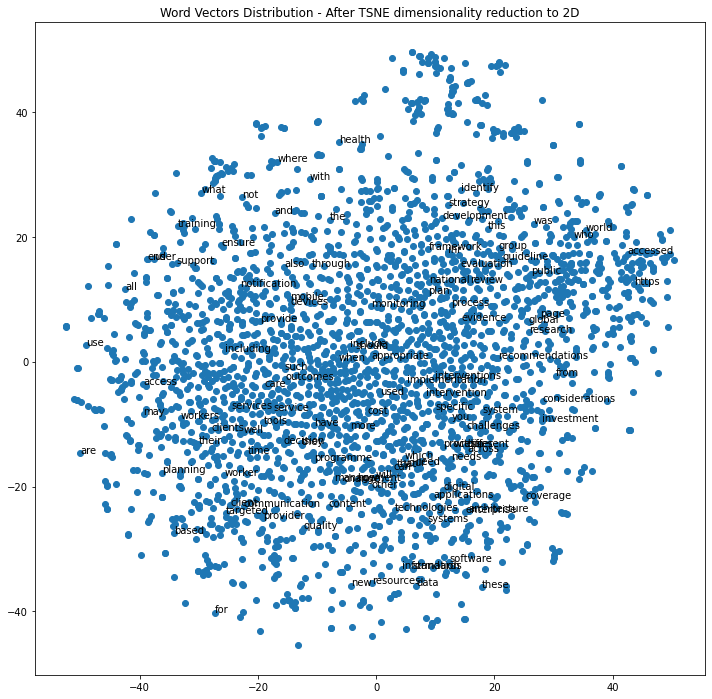

In [91]:
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_with_matplotlib(x_vals, y_vals, labels):
    random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(labels)))
    selected_indices = indices[:120]
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i])) ## annotate on the plot 10 randomly chosen words
    plt.title('Word Vectors Distribution - After TSNE dimensionality reduction to 2D')
    # plt.savefig('word_vectors_distribution.png', bbox_inches='tight', facecolor='w')
        
    
x_vals, y_vals, labels = reduce_dimensions(model)
plot_with_matplotlib(x_vals, y_vals, labels)